<b>Ontology based topic modelling</b>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from nltk.corpus import wordnet as wn
import nltk
from itertools import chain
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
from scipy import spatial

/home/tim/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<b>Get data from excel file</b>

In [2]:
excel_files = [['keywords_anger.xlsx', 'anger'], 
               ['keywords_garbage_non_existent.xlsx', 'garbage_non_existent'],
               ['keywords_climate_change.xlsx', 'climate_change'],
               ['keywords_impuls.xlsx', 'impuls'],
               ['keywords_network.xlsx', 'network'],
               ['keywords_student_well_being.xlsx', 'student_well_being'],
              ]
top_keywords = {}
for filename, theme in excel_files:
    data = pd.read_excel(filename)
    data.columns
    data = data.to_numpy()
    clus_0, clus_1, clus_2, clus_3 = [], [], [], []
    for row in data[:12]:
        if isinstance(row[0], str):
            clus_0.append([row[0], row[1]])
        if isinstance(row[2], str):
            clus_1.append([row[2], row[3]])
        if isinstance(row[4], str):
            clus_2.append([row[4], row[5]])
        if isinstance(row[6], str):
            clus_3.append([row[6], row[7]])

    clus_0, clus_1 = np.array(clus_0), np.array(clus_1)
    clus_2, clus_3 = np.array(clus_2), np.array(clus_3)
    top_keywords[theme] = [clus_0, clus_1, clus_2, clus_3]

In [3]:
print(clus_0)

[['breakfast' '0.2837905734399815']
 ['drink' '0.2606211386909435']
 ['mug' '0.22517216175649105']
 ['meal' '0.22517216175649105']
 ['tea' '0.22517216175649105']
 ['hot' '0.22517216175649105']
 ['lunch' '0.22517216175649105']
 ['dinner' '0.22517216175649105']
 ['food' '0.216438859363316']
 ['tableware' '0.2128429300799861']
 ['cup' '0.2128429300799861']
 ['dawn' '0.20327963502366286']]


In [4]:
def get_hypernym_path(clus):
    # Convert keyword to Wordnet synset and store hypernym path
    # Return list with synsets and their hypernyms.
    term_list = []
    for tag, score in clus:
        if ' ' in tag:
            # Compound words are not included
            continue
        if wn.synsets(tag) != []:
            syn = wn.synsets(tag)[0]
        else:
            # Cant find word in WordNet
            continue
        if syn.pos() not in ['n', 'v']:
            syn = wn.synsets(syn.lemmas()[0].name())[0]
        
        
        for path in syn.hypernym_paths():
            term_list.append([syn, score, path])
    return np.array(term_list)

clus_0, clus_1, clus_2, clus_3 = top_keywords['network']
clus0_hypernyms = get_hypernym_path(clus_0)
clus1_hypernyms = get_hypernym_path(clus_1)
clus2_hypernyms = get_hypernym_path(clus_2)
clus3_hypernyms = get_hypernym_path(clus_3)

hypernym_paths = {}
for theme in top_keywords.keys():
    tmp = []
    for clus in top_keywords[theme]:
        hypernym = get_hypernym_path(clus)
        tmp.append(hypernym)
    hypernym_paths[theme] = tmp

In [40]:
#wn.synset('man.n.01').hypernym_paths()

In [5]:
def create_graph(data):
    G = nx.DiGraph()
    for syn, score, path in data:
        i = 0
        path_len = len(path)
        while i+1 < path_len:
            parent = path[i].lemmas()[0].name()
            child = path[i+1].lemmas()[0].name()
            if G.has_edge(parent,child):
                i += 1
                continue
            else:
                G.add_edge(parent,child)
                G.nodes[child]['weight'] = 0
                G.nodes[parent]['weight'] = 0
                i += 1
    return G

graph_clus0 = create_graph(clus0_hypernyms)
graph_clus1 = create_graph(clus1_hypernyms)
graph_clus2 = create_graph(clus2_hypernyms)
graph_clus3 = create_graph(clus3_hypernyms)

graphs = {}
for theme in hypernym_paths.keys():
    tmp = []
    for clus in hypernym_paths[theme]:
        G = create_graph(clus)
        tmp.append(G)
    graphs[theme] = tmp

In [11]:

cycle = list(nx.simple_cycles(graph_clus3))
for theme in graphs.keys():
    for clus in graphs[theme]:
        cycle = list(nx.simple_cycles(clus))
        if cycle != []:
            print(theme)
            print(cycle)

#graphs['anger'][1].remove_edge('cognition', 'content')



print()

In [13]:
# Start with all end nodes, recursively go down and assign weight based on children
def get_children(G, node):
    weight = 0
    children = G.successors(node)
    for child in list(children):
        if G.out_degree(child) != 0:
            G = get_children(G, child)
        weight += G.nodes[child]['weight']
    G.nodes[node]['weight'] = weight
    return G

def assign_weights(G, cluster):
    # First level weights
    for tag, score, path in cluster:
        node = tag.lemmas()[0].name()
        try:
            G.nodes[node]['weight'] = float(score)
        except KeyError:
            print(node)
            continue
    # Assign weights to all nodes based on children
    end_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
    for end_node in end_nodes:
        G = get_children(G, end_node)
    return G

# G0 = assign_weights(graph_clus0, clus0_hypernyms)
# G1 = assign_weights(graph_clus1, clus1_hypernyms)
# G2 = assign_weights(graph_clus2, clus2_hypernyms)
# G3 = assign_weights(graph_clus3, clus3_hypernyms)

graphs_with_weight = {}
for theme in hypernym_paths.keys():
    tmp = []
    for i, clus in enumerate(hypernym_paths[theme]):
        G = assign_weights(graphs[theme][i], clus)
        tmp.append(G)
    graphs_with_weight[theme] = tmp



urban
urban
urban
casual
hot
urban


<b>Generate abstract label from network</b>
<br>
Return the node with max weight at max 3 steps from leaf nodes(keywords)

In [24]:
def get_maxweight_node(G):
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
    path_list = []
    for node in G.nodes():
        if node not in leaf_nodes:
            # Get all paths from node to leaf nodes, take the highest node
            path_list.append(nx.all_simple_paths(G, node, leaf_nodes, cutoff=1))

    max_parents = []
    for paths in path_list:
        for path in paths:
            max_parents.append(path[0])

    max_weight = 0
    max_node = ''
    for node in max_parents:
        weight = G.nodes[node]['weight']
        if weight > max_weight:
            max_node = node
            max_weight = weight
    return max_node

# max_node0 = get_maxweight_node(G0)
# max_node1 = get_maxweight_node(G1)
# max_node2 = get_maxweight_node(G2)
# max_node3 = get_maxweight_node(G3)

In [25]:
best_hypernyms = {}
for theme in graphs_with_weight.keys():
    tmp = []
    for clus in graphs_with_weight[theme]:
        max_node = get_maxweight_node(clus)
        tmp.append(max_node)
    best_hypernyms[theme] = tmp
best_hypernyms['network'][1] = 'network'
for theme in best_hypernyms.keys():
    print(theme)
    print(best_hypernyms[theme])

anger
['activity', 'past', 'municipality', 'group']
garbage_non_existent
['creation', 'substance', 'group', 'waste']
climate_change
['thoroughfare', 'group', 'tract', 'substance']
impuls
['motion', 'material', 'application', 'group']
network
['region', 'network', 'clothing', 'computer_network']
student_well_being
['meal', 'motion', 'application', 'group']


<b>Antonyms</b>

In [26]:
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True, limit=1500000)

In [27]:
# Return list of antonyms
def create_antonym_list():
    all_antonyms = []
    for i in wn.all_synsets():
        if i.pos() in ['a', 's']:
            for j in i.lemmas():
                if j.antonyms(): 
                    # Prints the adj-antonym pair.
                    ant = j.name(), j.antonyms()[0].name()
                    all_antonyms.append(ant)
    return all_antonyms

all_antonyms = create_antonym_list()
all_antonyms = sorted(set(tuple(sorted(i)) for i in all_antonyms))


In [28]:
# Returns most relevant antonym for a given word
def most_relevant_antonym(hypernym, all_antonyms):
    result = tuple()
    best_score = 0
    for ant_tuple in all_antonyms:
        score = 0
        for ant in ant_tuple:
            try:
                if len(wn.synsets(ant)) != 0:
                    score = model.similarity(hypernym, ant)
            except KeyError:
                continue
            if score > best_score:
                best_score = score
                result = (ant_tuple, best_score)
    return result

best_antonym = {}
for theme in best_hypernyms.keys():
    tmp = []
    for hypernym in best_hypernyms[theme]:
        antonym = most_relevant_antonym(hypernym, all_antonyms)
        tmp.append(antonym)
    best_antonym[theme] = tmp

for theme in best_antonym.keys():
    print(best_antonym[theme])  
    best_antonym[theme].sort(key=lambda x: bool(x) and x[1])
    best_antonym[theme] = best_antonym[theme][-2:]

    print("best hypernyms: ")
    print(best_hypernyms[theme])
    print("best antonyms")
    print(best_antonym[theme])
    print()



[(('active', 'dormant'), 0.3578612), (('future', 'past'), 1.0), (('cosmopolitan', 'provincial'), 0.49891207), (('disorganized', 'organized'), 0.2976603)]
best hypernyms: 
['activity', 'past', 'municipality', 'group']
best antonyms
[(('cosmopolitan', 'provincial'), 0.49891207), (('future', 'past'), 1.0)]

[(('stimulating', 'unstimulating'), 0.35332832), (('nonpsychoactive', 'psychoactive'), 0.4305448), (('disorganized', 'organized'), 0.2976603), (('thrifty', 'wasteful'), 0.4814475)]
best hypernyms: 
['creation', 'substance', 'group', 'waste']
best antonyms
[(('nonpsychoactive', 'psychoactive'), 0.4305448), (('thrifty', 'wasteful'), 0.4814475)]

[(('downtown', 'uptown'), 0.4997764), (('disorganized', 'organized'), 0.2976603), (('developed', 'undeveloped'), 0.54836), (('nonpsychoactive', 'psychoactive'), 0.4305448)]
best hypernyms: 
['thoroughfare', 'group', 'tract', 'substance']
best antonyms
[(('downtown', 'uptown'), 0.4997764), (('developed', 'undeveloped'), 0.54836)]

[(('amended', 'u

In [ ]:
# theme, x_top, x_bottom, y_top, y_bottom, 
# top_left, top_right, bottom_left, bottom_right


<b>Place labels on graphic figure, END RESULT </b>

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def fourcluster_categorization(theme, data):
    top_left, top_right, bottom_left, bottom_right = data
    
    fig,ax = plt.subplots()
    fig.set_size_inches(12,12)    
    
    ax.plot([5,5],[1,9], linewidth=4, color='white' )
    ax.plot([1,9],[5,5], linewidth=4, color='white' )

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    rect = patches.Rectangle((1, 1), 4, 4, linewidth=1, edgecolor='r', facecolor='red', alpha=0.1)
    ax.add_patch(rect)
    plt.text(1.5, 4.1, bottom_left,fontsize=20, color="red", weight="bold")

    rect = patches.Rectangle((1, 5), 4, 4, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)
    ax.add_patch(rect)
    plt.text(1.5, 8.1, top_left,fontsize=20, color="blue", weight="bold")

    rect = patches.Rectangle((5, 1), 4, 4, linewidth=1, edgecolor='r', facecolor='green', alpha=0.1)
    ax.add_patch(rect)
    plt.text(5.5, 4.1,bottom_right,fontsize=20, color="green", weight="bold")

    rect = patches.Rectangle((5, 5), 4, 4, linewidth=1, edgecolor='r', facecolor='purple', alpha=0.1)
    ax.add_patch(rect)
    plt.text(5.5, 8.1,top_right,fontsize=20, color="purple", weight="bold")
    plt.title('Categorization\n' + str(theme), fontsize=20)
    
    return fig,ax

def fourcluster_axis(theme, data):
    x_top, x_bottom, y_top, y_bottom = data[0][0][0], data[0][0][1], data[1][0][0], data[1][0][1]
    
    fig,ax = plt.subplots()
    fig.set_size_inches(12,12)
    # Hold activation for multiple lines on same graph
    # Set x-axis range
    # Draw lines to split quadrants
    ax.plot([5,5],[1,9], linewidth=4, color='black' )
    ax.plot([1,9],[5,5], linewidth=4, color='black' )

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.text(1, 5.1, x_bottom,fontsize=16, color="black", weight="bold")
    plt.text(8, 5.1, x_top,fontsize=16, color="black", weight="bold")
    plt.text(5.1, 1,y_bottom,fontsize=16, color="black", weight="bold")
    plt.text(5.1, 8.9,y_top,fontsize=16, color="black", weight="bold")

    plt.title('Quadrant frame\n' + str(theme), fontsize=20)
    return fig,ax


In [93]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

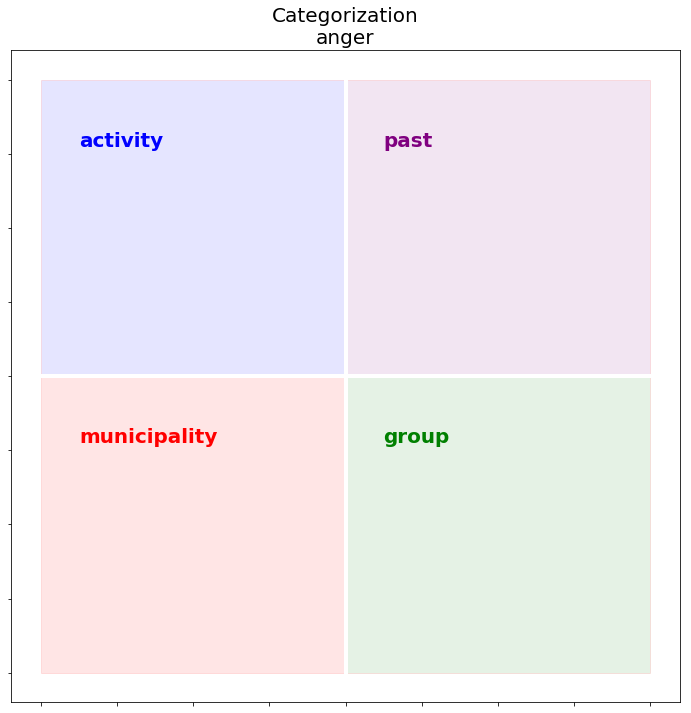

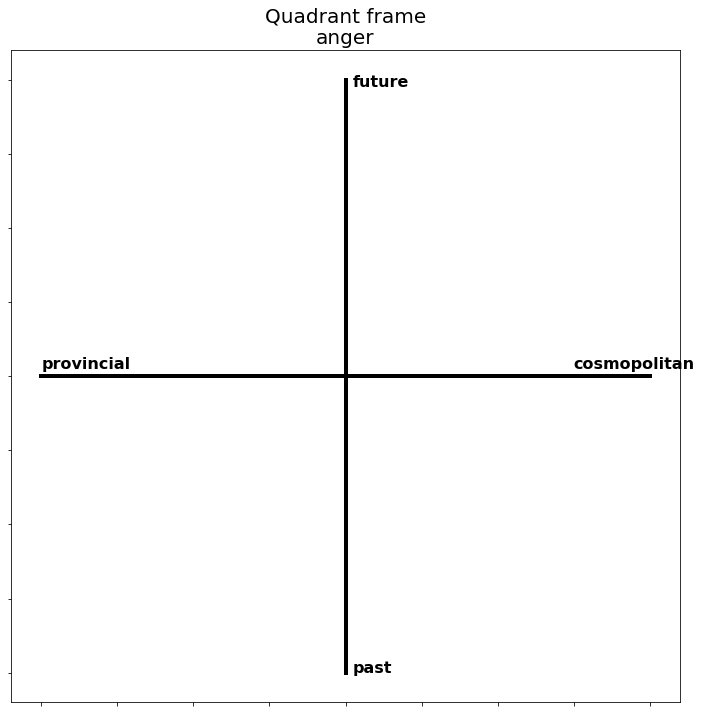

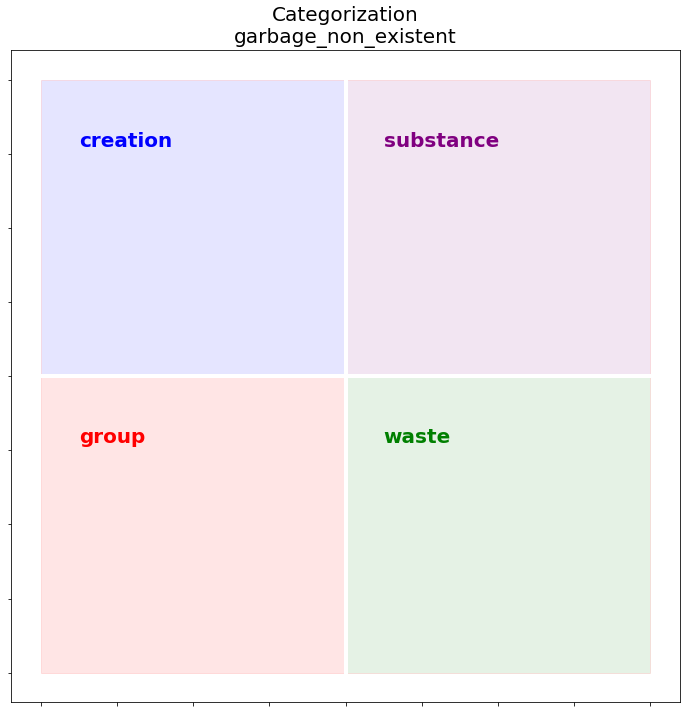

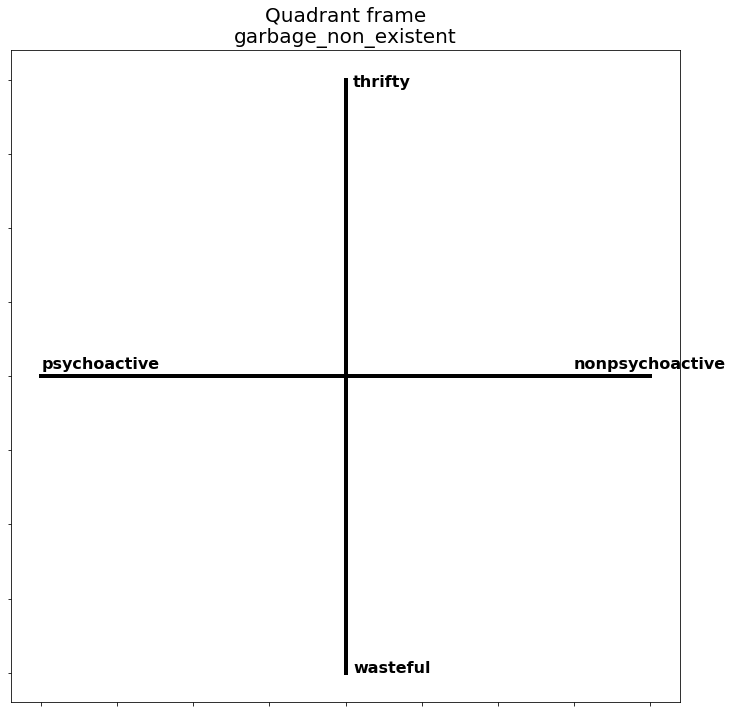

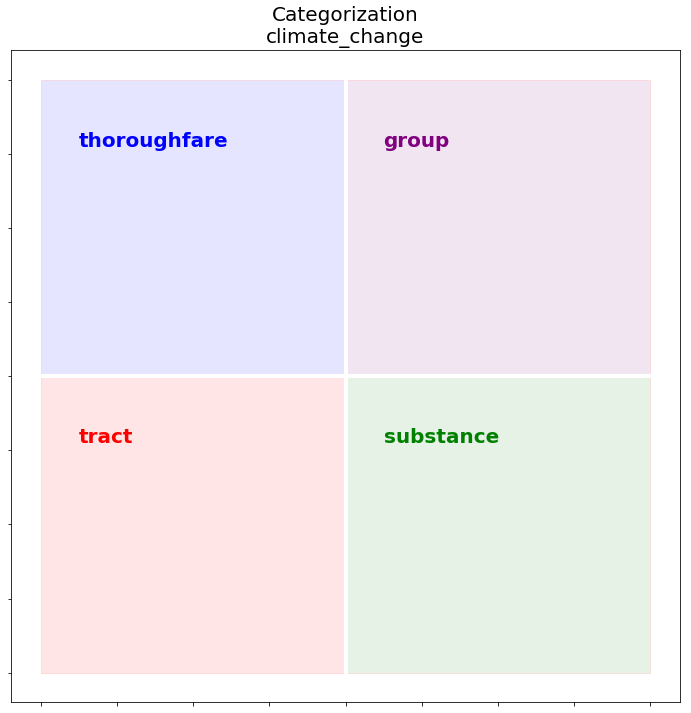

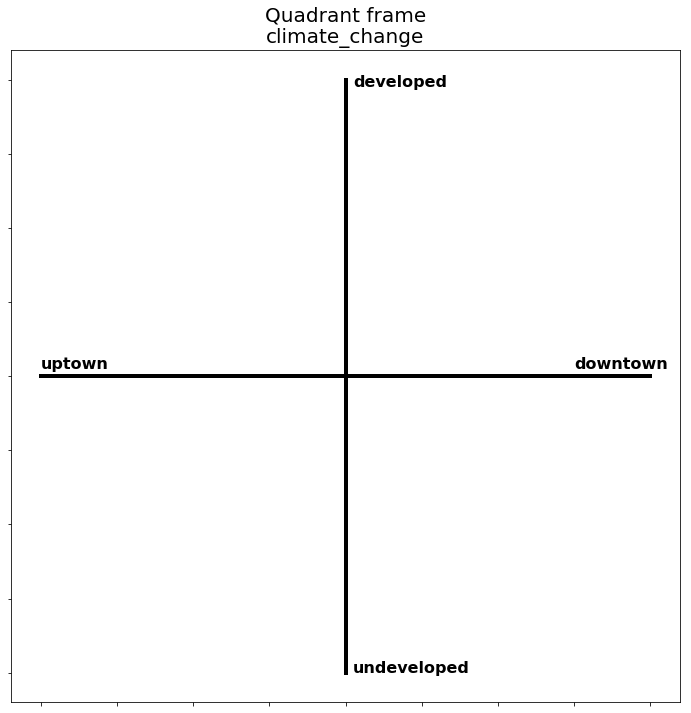

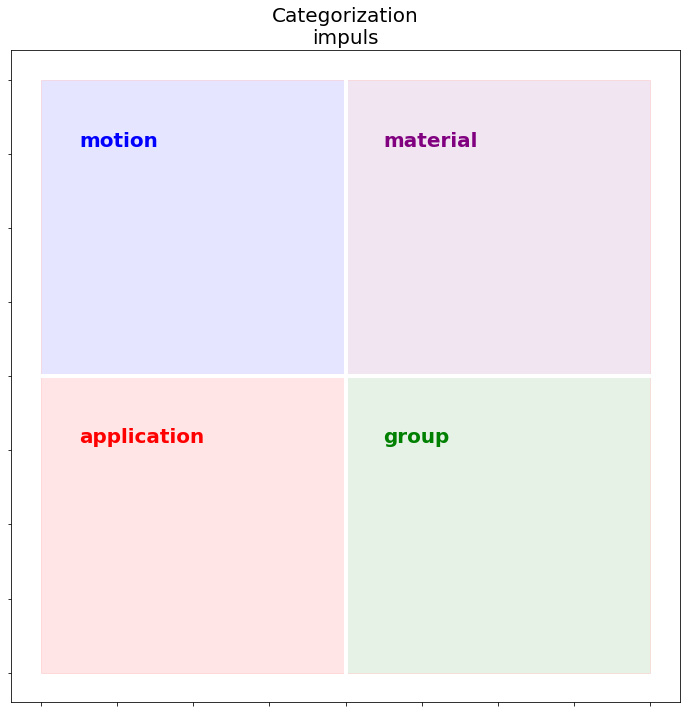

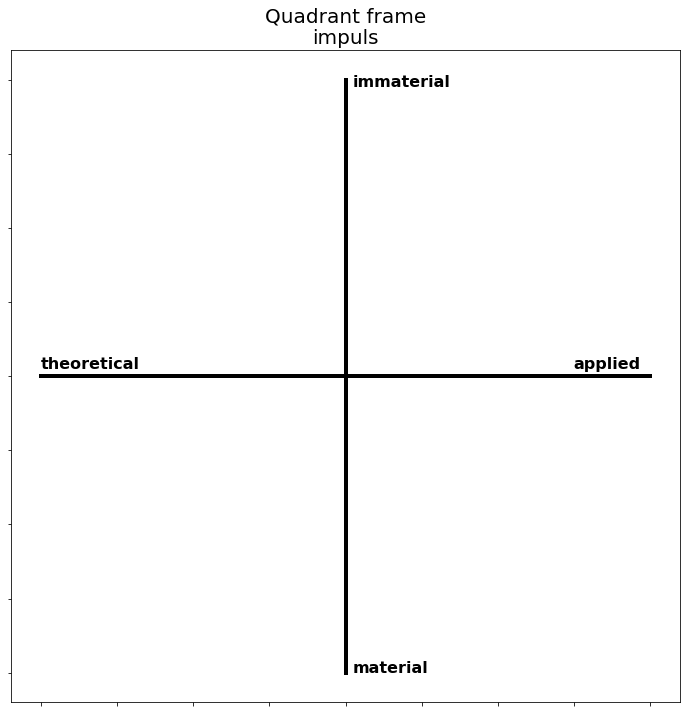

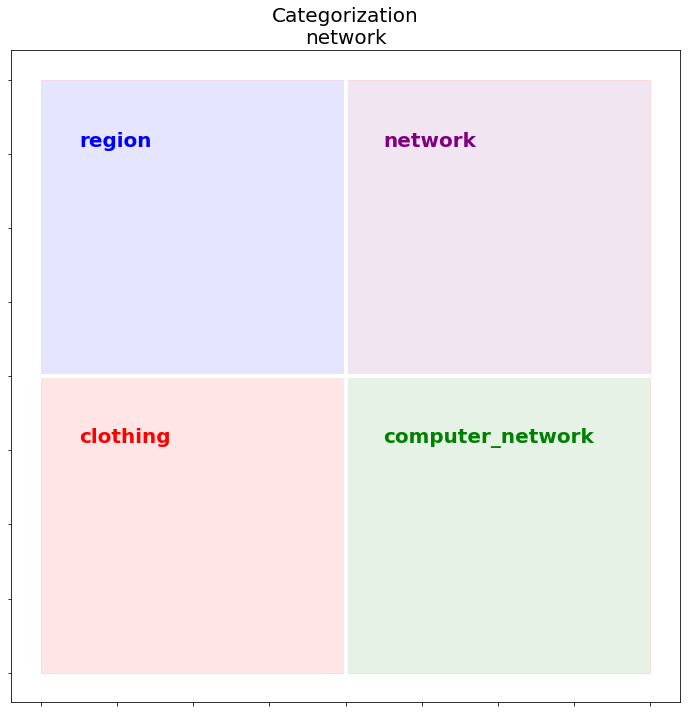

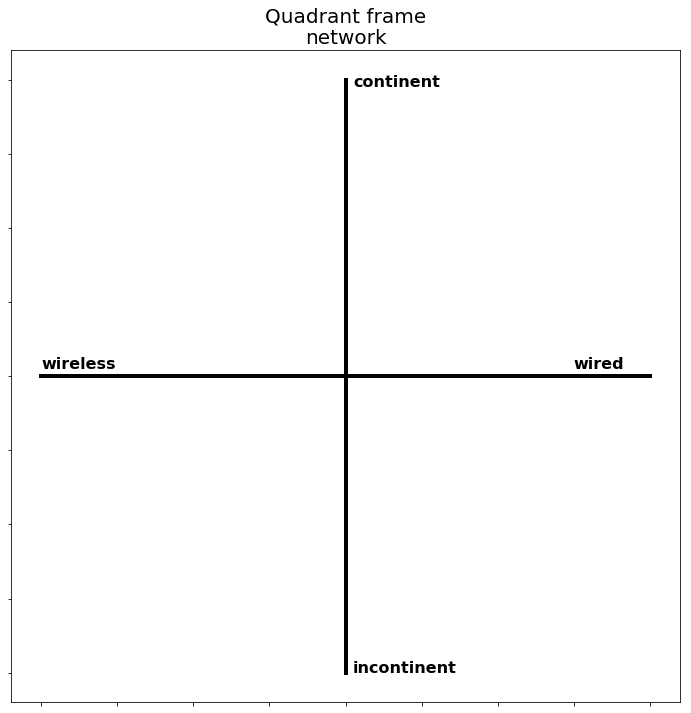

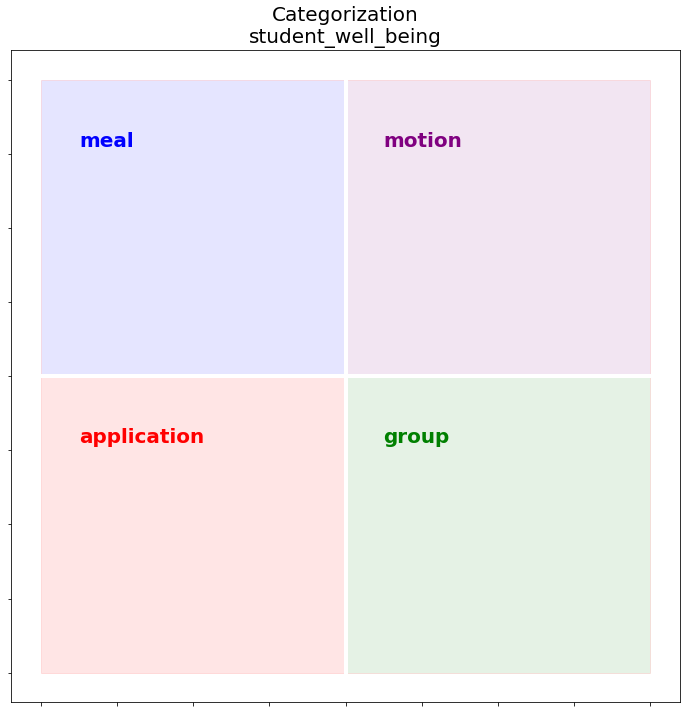

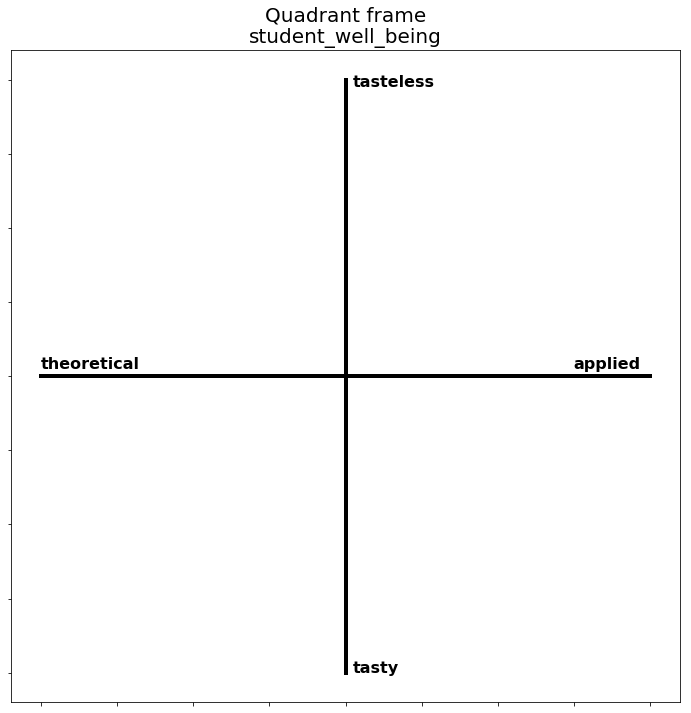

In [94]:

for theme in best_antonym.keys():
    best_antonym[theme].sort(key=lambda x:x[1])
    best_antonym[theme] = best_antonym[theme][-2:]
    fig, ax = fourcluster_categorization(theme, best_hypernyms[theme])
    plt.show()
    fig, ax = fourcluster_axis(theme, best_antonym[theme])
    plt.show()